# PCA on 4000 Spectra

Recreating https://ogrisel.github.io/scikit-learn.org/sklearn-tutorial/tutorial/astronomy/dimensionality_reduction.html with 4000 spectra generated from compute_sdss_pca.py

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.decomposition import PCA

## 1. Load and prepare data

In [3]:
# Load full data set
data = np.load('spec4000error.npz')

In [4]:
# Calculating wavlength grid from coefficients
log_wavelengths = data['coeff0'] + data['coeff1'] * np.arange(0, 1000, 1)
wavelengths = [10**i for i in log_wavelengths]

In [7]:
#%% Selecting only galaxies (spec_cln = 2)
galaxy_ind = data['spec_cln'] == 2
X = data['spectra'][galaxy_ind]
subclass = data['lineindex_cln'][galaxy_ind]
z = data['z'][galaxy_ind]
z_err = data['zerr'][galaxy_ind]
spec_err = data['spec_err'][galaxy_ind]

In [8]:
#%% Set any negative spikes in flux to zero and set the corresponding error to zero
neg_ind = X <= 0.
X[neg_ind] = 0.
spec_err[neg_ind] = 0.

In [9]:
#%% Set zero fluxes to NaN
X_nonan = X.copy()
zero_ind = X == 0.
X[zero_ind] = np.NaN

In [10]:
#%% Set all zero flux errors to NaN
zero_err_ind = spec_err == 0.
spec_err[zero_err_ind] = np.NaN

## 2. Normalise X and plot mean spectrum

In [11]:
#%% Normalise spectrum
X_normal, norm = preprocessing.normalize(X_nonan, return_norm=True)
X_norm_zeros = np.copy(X_normal)

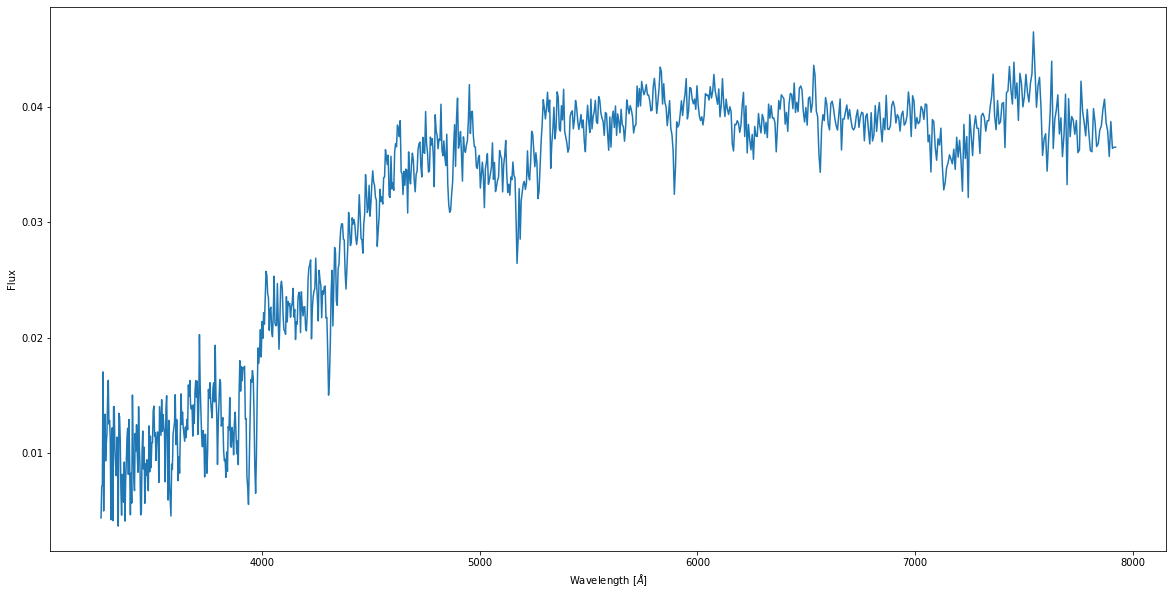

In [17]:
#%% Plot an example spectrum in the data
plt.figure(figsize=(20,10))
plt.plot(wavelengths,X_normal[4])
plt.xlabel('Wavelength [$\AA$]')
plt.ylabel('Flux')
plt.show()

In [13]:
#%% Set all zero normalised fluxes to nan
zero_norm_ind = X_normal == 0.
X_normal[zero_norm_ind] = np.NaN

In [14]:
#%% Transform errors due to corresponding normalisation
spec_err_T = np.transpose(spec_err)
spec_err_norm_T = np.divide(spec_err_T,norm)
spec_err_norm = np.transpose(spec_err_norm_T)

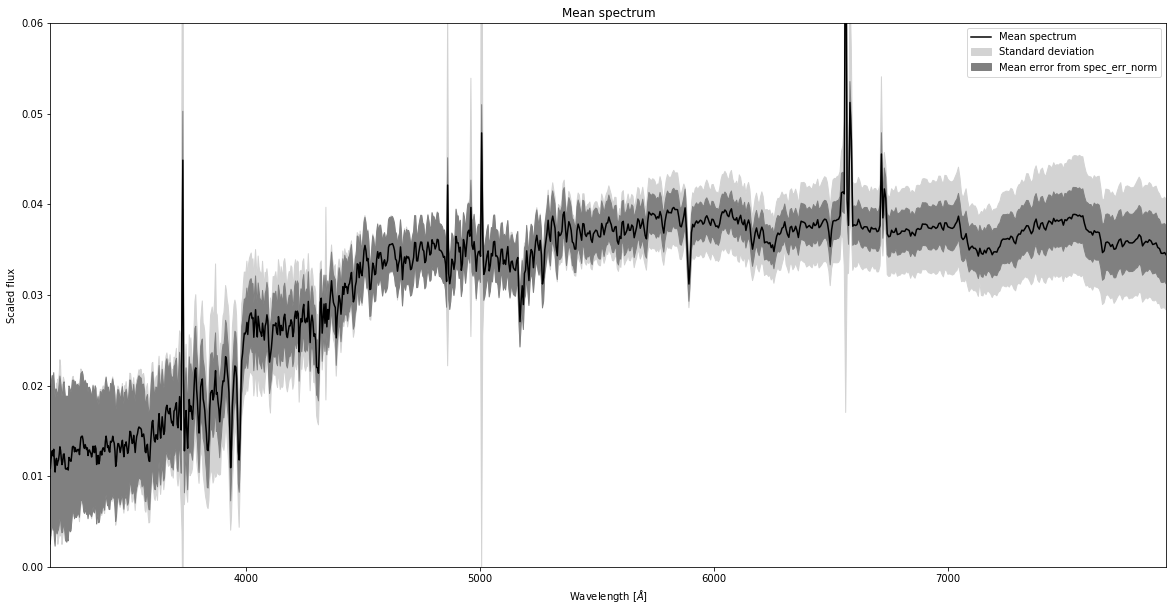

In [20]:
#%% Plot mean spectrum
mu = np.nanmean(X_normal, axis=0)
std = np.nanstd(X_normal, axis=0)
#mu = X_norm_zeros.mean(0)
#std = X_norm_zeros.std(0)
mean_err = np.nanmean(spec_err_norm, axis=0)
plt.figure(figsize=(20,10))
plt.plot(wavelengths, mu, color = 'black', label='Mean spectrum')
plt.fill_between(wavelengths, mu - std, mu + std , color = 'lightgrey', label='Standard deviation')
plt.fill_between(wavelengths, mu - mean_err, mu + mean_err , color = 'grey', label = 'Mean error from SDSS')
plt.xlim(wavelengths[0], wavelengths[-1])
plt.ylim(0,0.06)
plt.xlabel('Wavelength [$\AA$]')
plt.ylabel('Scaled flux')
plt.title('Mean spectrum')
plt.legend()
plt.show()

## 3. Apply PCA

In [22]:
pca = PCA(n_components=4)
X_red = pca.fit_transform(X_norm_zeros)

## 4. Plot the cofficients from X_red against each other

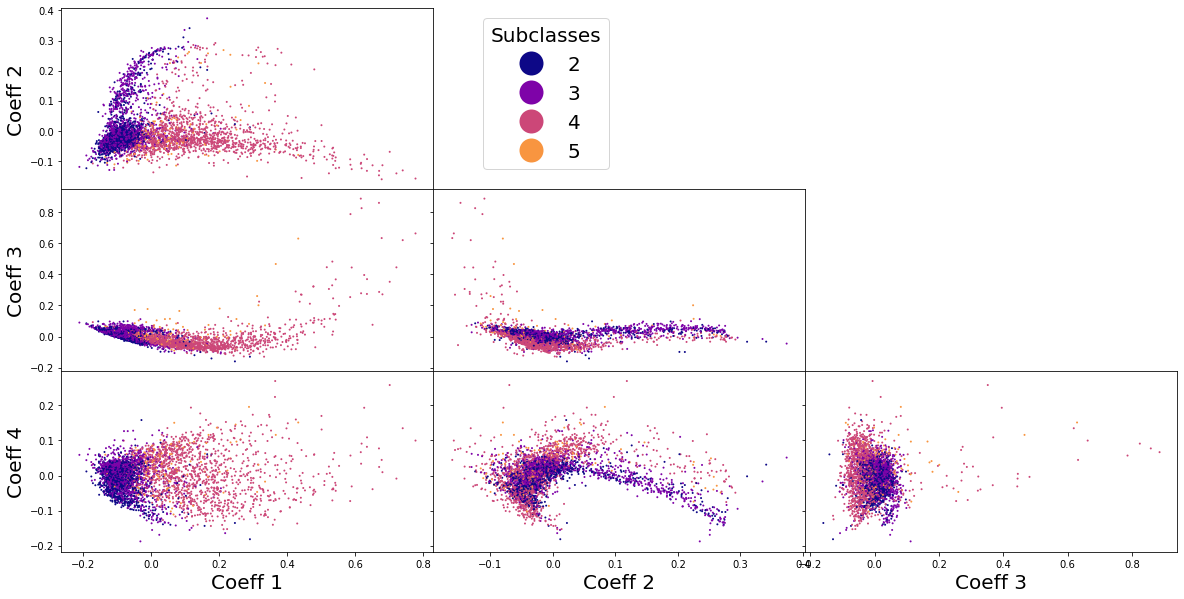

In [24]:
plt.figure(figsize=(20,10))
plt.rc('xtick',labelsize=10)
plt.rc('ytick',labelsize=10)
plt.set_cmap('plasma')

ax1 = plt.subplot(3,3,1)
scatter1 = ax1.scatter(X_red[:, 0], X_red[:, 1], c = subclass, s=4, lw=0, vmin=2, vmax=6)
ax1.set_ylabel('Coeff 2', fontsize=20)

ax2 = plt.subplot(3,3,4)
ax2.scatter(X_red[:, 0], X_red[:, 2], c = subclass, s=4, lw=0, vmin=2, vmax=6)
ax2.set_ylabel('Coeff 3', fontsize=20)

ax3 = plt.subplot(3,3,5)
ax3.scatter(X_red[:, 1], X_red[:, 2], c = subclass, s=4, lw=0, vmin=2, vmax=6)

ax4 = plt.subplot(3,3,7)
ax4.scatter(X_red[:, 0], X_red[:, 3], c = subclass, s=4, lw=0, vmin=2, vmax=6)
ax4.set_xlabel('Coeff 1', fontsize=20)
ax4.set_ylabel('Coeff 4', fontsize=20)

ax5 = plt.subplot(3,3,8)
ax5.scatter(X_red[:, 1], X_red[:, 3], c = subclass, s=4, lw=0, vmin=2, vmax=6)
ax5.set_xlabel('Coeff 2', fontsize=20)

ax6 = plt.subplot(3,3,9)
ax6.scatter(X_red[:, 2], X_red[:, 3], c = subclass, s=4, lw=0, vmin=2, vmax=6)
ax6.set_xlabel('Coeff 3', fontsize=20)

plt.subplots_adjust(hspace=.0, wspace=.0)
axs = np.array([ax1, ax2, ax3, ax4, ax5, ax6])
for ax in axs.flat:
    ax.label_outer()
    
ax1.legend(*scatter1.legend_elements(), bbox_to_anchor=(1.5, 1), title="Subclasses",
                     fontsize=20, title_fontsize=20, markerscale=4)

plt.show()

## 5. Plot the mean spectrum and the first four eigenvectors of the spectral data

Text(0.5, 1.0, 'Mean Spectrum and Eigen-spectra')

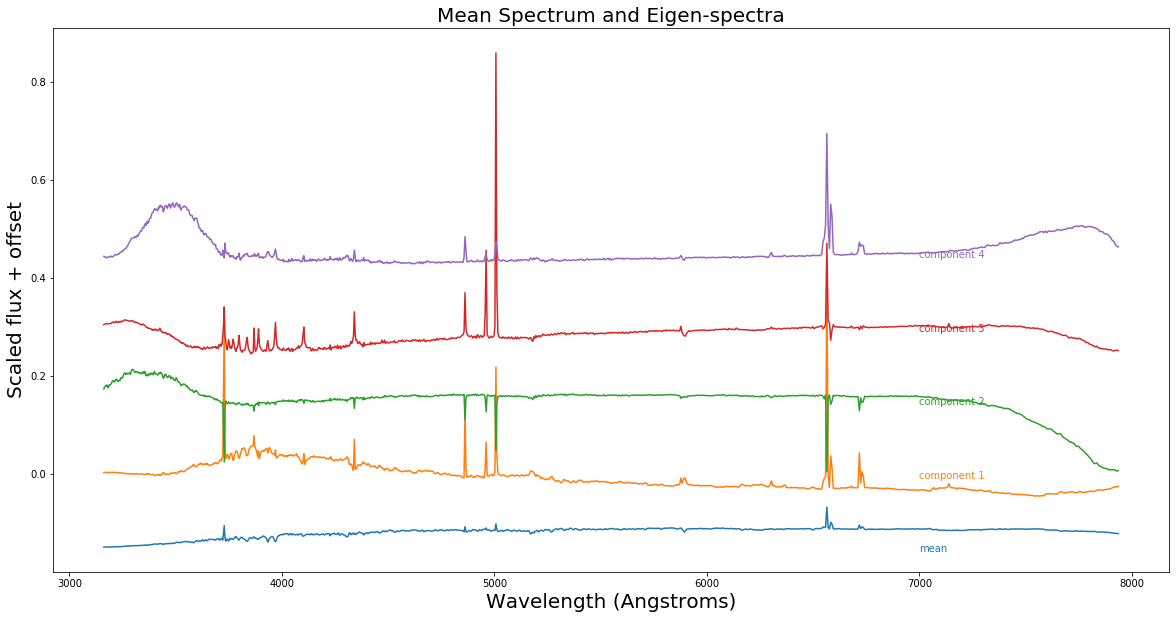

In [27]:
plt.figure(figsize=(20,10))
l = plt.plot(wavelengths, pca.mean_ - 0.15)
c = l[0].get_color()
plt.text(7000, -0.16, "mean", color=c)
for i in range(4):
    l = plt.plot(wavelengths, pca.components_[i] + 0.15 * i)
    c = l[0].get_color()
    plt.text(7000, -0.01 + 0.15 * i, "component %i" % (i + 1), color=c)
#plt.ylim(-0.2, 0.6)
plt.xlabel('Wavelength (Angstroms)', fontsize=20)
plt.ylabel('Scaled flux + offset', fontsize=20)
plt.title('Mean Spectrum and Eigen-spectra', fontsize=20)

## 6. Plot variance explained by each component

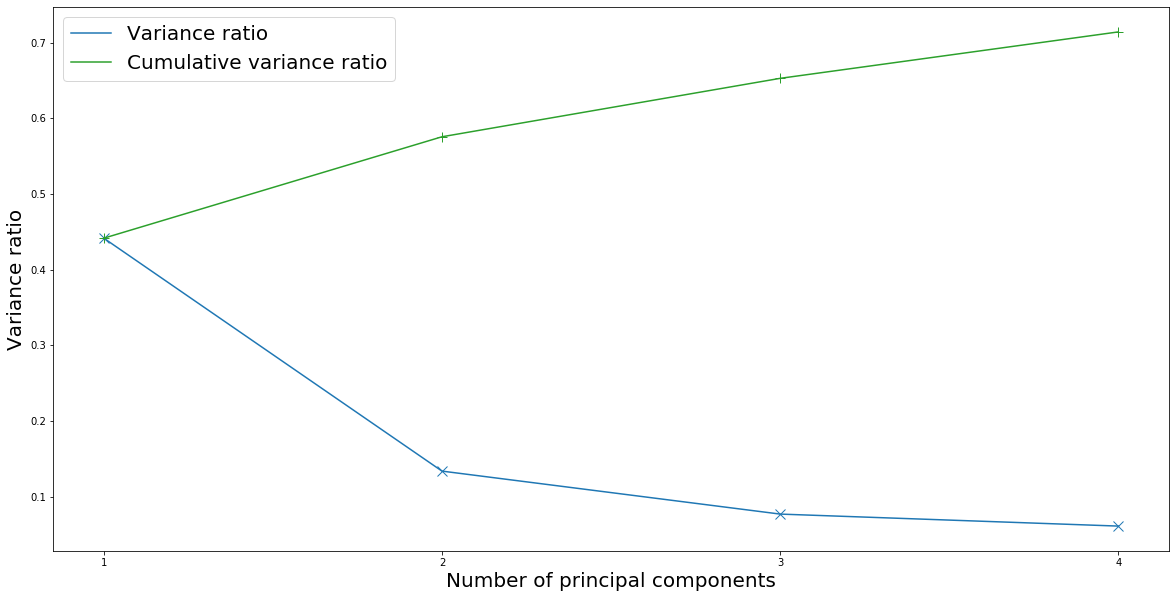

In [28]:
var = pca.explained_variance_ratio_
cum_var = np.cumsum(var)
plt.figure(figsize=(20,10))
plt.plot(np.array(range(1,pca.n_components_+1)), var, 'x', color='tab:blue', markersize=10)
plt.plot(np.array(range(1,pca.n_components_+1)), var, color='tab:blue', label='Variance ratio')
plt.plot(np.array(range(1,pca.n_components_+1)), cum_var, '+', color='tab:green', markersize=10)
plt.plot(np.array(range(1,pca.n_components_+1)), cum_var, color='tab:green', label='Cumulative variance ratio')
plt.xlabel('Number of principal components',fontsize=20)
plt.ylabel('Variance ratio',fontsize=20)
plt.xticks(np.array(range(1,pca.n_components_+1)))
plt.legend(fontsize=20)
plt.show()

## 7. Reconstruct a random individual spectra

In [31]:
# Define function for plotting individual spectra
def reconstruct_spectra(spectra_num):
    coeff = np.dot(pca.components_, X_norm_zeros[spectra_num] - pca.mean_)
    fig = plt.figure(figsize=(20,10))
    for i, n in enumerate(range(5)):
        ax = fig.add_subplot(511 + i)
        ax.plot(wavelengths, X_norm_zeros[spectra_num], '-', c='gray')
        ax.plot(wavelengths, pca.mean_ + np.dot(coeff[:n], pca.components_[:n]), '-k')
    
        if i < 3:
            ax.xaxis.set_major_formatter(plt.NullFormatter())
    
        ax.set_ylabel('flux', fontsize=20)
    
        if n == 0:
            text = "mean"
        elif n == 1:
            text = "mean + 1 component\n"
            text += r"$(\sigma^2_{tot}$ ratio $= %.2f)$" % cum_var[n - 1]
        else:
            text = "mean + %i components\n" % n
            text += r"$(\sigma^2_{tot}$ ratio $= %.2f)$" % cum_var[n - 1]
    
        ax.text(0.02, 0.93, text, ha='left', va='top', transform=ax.transAxes)
    
    fig.axes[-1].set_xlabel(r'${\rm wavelength\ (\AA)}$', fontsize=20)
    fig.suptitle(f'Reconstruction of Spectra {spectra_num}', fontsize=20)
    plt.show()

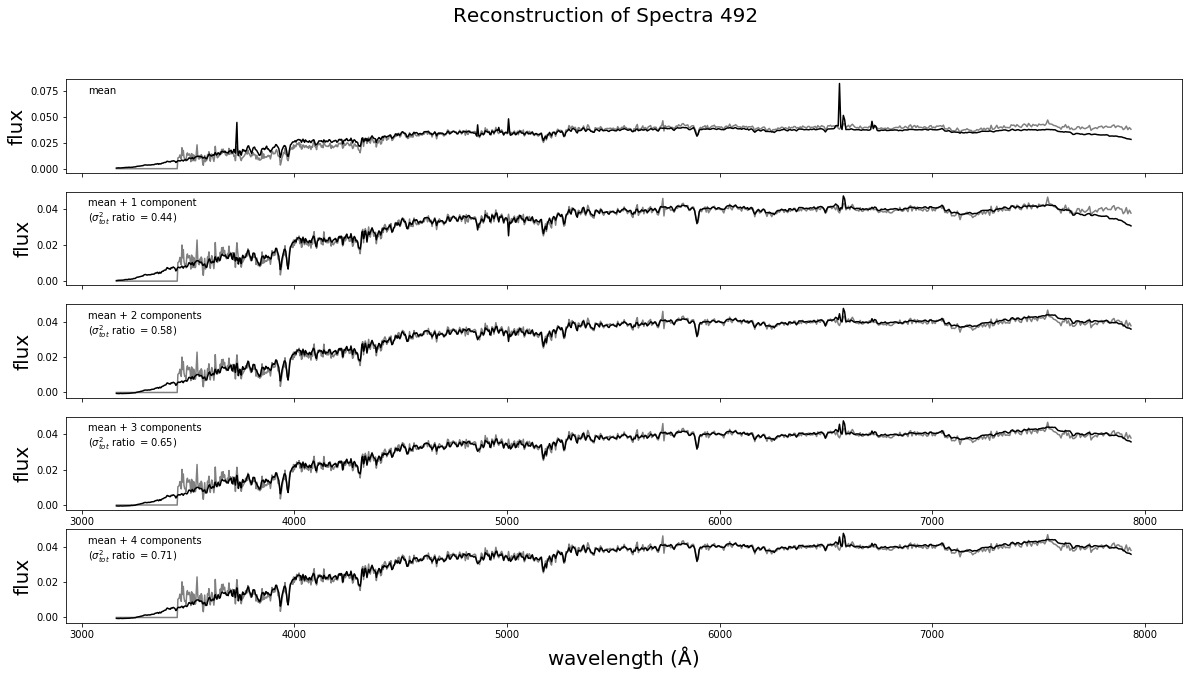

In [32]:
# Plot a random spectra
spectra_num = np.random.randint(0, len(X))
reconstruct_spectra(spectra_num)